<a href="https://colab.research.google.com/github/beheddin/photo-face-recognition-app/blob/google-colab/photo_face_recognition_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accès aux données du dataset

1. Connexion au Drive Google:

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Accès au dataset:

Chemin du projet:

In [ ]:
base_path = "/content/drive/MyDrive/photo-face-recognition-app"

Chemin du dataset d'images:

In [ ]:
def createFileOrFolderPath(base_path, file_or_folder_name):
    import os
    return os.path.join(base_path, file_or_folder_name)

In [ ]:
dataset_imgs_folder_path = createFileOrFolderPath(base_path, "dataset_images")
dataset_imgs_folder_path

'/content/drive/MyDrive/photo-face-recognition-app/dataset_images'

In [ ]:
def getFolderContent(folder_path):
    import os
    return os.listdir(folder_path)

In [ ]:
 dataset_imgs_folder_content = getFolderContent(dataset_imgs_folder_path)
 dataset_imgs_folder_content

['Vitalik Buterin',
 'Lewis Hamilton',
 'elon-musk',
 'Beheddin',
 'Kevin mitnick',
 'linus thorvalds']

#  Définition du modèle et préparation des données du dataset

1. Le modèle correspond à tout le dataset:

> les données d'entrée (X) du dataset sont les photos des visages extraites à partir des photos du dataset.

> les données de sortie (Y) sont les labels (nom des personnes) des visages détectés sur les photos du dataset.

2. Préparation des données du dataset:

Controler les formats et la taille des photos du dataset et celles entrées par l'utilisateur:

In [ ]:
def chooseImagesFormats():
    raster_imgs_formats = ["jpeg", "jpg", "png", "gif", "bmp", "webp"]

    while True:
        decision = input("voulez vous utilisez ces formats \"Raster\" pour vos images? validez par 'o': ")
        if decision.lower() == 'o':
            print("formats enregistrés.")
            return raster_imgs_formats
        else:
            imgs_formats = []
            while True:
                format = input("entrez un format d'image (jpg, png, etc): ")
                imgs_formats.append(format)
                decision = input("appuyez sur 'q' pour quitter? ")
                if decision.lower() == 'q':
                    print("formats enregistrés.")
                    return imgs_formats

In [ ]:
imgs_formats = chooseImagesFormats()

voulez vous utilisez ces formats "Raster" pour vos images? validez par 'o': o
formats enregistrés.


Controler la taille (dimension) des images: définir une taille standard de toutes les images.

In [ ]:
def setImageSize():
    print("- entrez les dimensions d'une image \"Portrait\" avec un rapport de 3:4 -")
    print("exemples: 384*512, 480*640, 600*800, 768*1024, etc")
    while True:
        width = int(input("entrez la largeur de l'image: "))
        height = int(input("entrez la hauteur de l'image: "))
        if(width < height) and (width / height == 3 / 4):
            break
        else:
            print("la largeur d'une image Portrait ne peut pas etre supérieure à sa hauteur!")
            print("le rapport entre la largeur de l'image sur sa hauteur n'est pas égale à 3:4!")
    return width, height

In [ ]:
img_size = setImageSize()

- entrez les dimensions d'une image "Portrait" avec un rapport de 3:4 -
exemples: 384*512, 480*640, 600*800, 768*1024, etc
entrez la largeur de l'image: 480
entrez la hauteur de l'image: 640


Il faut également définir quelques fonctions qui effectent les traitements pour la préparation des données du dataset:

In [ ]:
def readImage(img_path):
    # Read an image from a file
    import cv2

    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    return img

In [ ]:
def resizeImage(img, img_size):
    import cv2
    # all imgs must be Portrait 3:4
    img_resized = cv2.resize(img, img_size)
    return img_resized

In [ ]:
def convertImageToGrayscale(img):
    # Convert an image to grayscale
    import cv2

    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_grayscale

In [ ]:
def writeImage(img_path, img):
    # Save an image in a file
    import cv2

    cv2.imwrite(img_path,img)
   
    print("image successfully written in: {}".format(img_path))

In [ ]:
def displayImageInWindow(img):
    # Display an image
    from google.colab.patches import cv2_imshow

    cv2_imshow(img)

In [ ]:
def verifyImageFormat(file, imgs_formats):
    for format in imgs_formats:
        if file.lower().endswith(format):
            return True
        else:
            continue
    return False

In [ ]:
def getImageLabel(file_path):
    # the label of an image is the name of the folder where the image is located
    import os
    return os.path.basename(file_path).replace(" " or "_", "-").lower()  # replace any space ' ' or underscore '_' with a dash '-' in the label's name and put it in lowercase


Chemin du classifieur:

In [ ]:
classifier_path = createFileOrFolderPath(base_path, "haarcascade_dataset/haarcascade_frontalface_default.xml")
classifier_path

'/content/drive/MyDrive/photo-face-recognition-app/haarcascade_dataset/haarcascade_frontalface_default.xml'

Saisir les params "scaleFactor" et "minNeighbors" pour la détection des visages sur les photos du dataset:

In [ ]:
def setScaleFactorAndMinNeighbors():
    print("entrez les parametres \"scaleFactor\" et \"minNeighbors\" de la fct \"detectMultiScale()\":")
    scaleFactor = float(input("scaleFactor (type \"float\") (ex: 1.3): "))
    minNeighbors = int(input("minNeighbors (type \"int\") (ex: 3): "))
    return scaleFactor, minNeighbors

In [ ]:
scaleFactor, minNeighbors = setScaleFactorAndMinNeighbors()

entrez les parametres "scaleFactor" et "minNeighbors" de la fct "detectMultiScale()":
scaleFactor (type "float") (ex: 1.3): 1.3
minNeighbors (type "int") (ex: 3): 3


Extraction des données d'entrée (X) et des données de sortie (Y) du dataset:

In [ ]:
def extractFacesAndLabelsFromDataset(dataset_path, imgs_formats, img_size, classifier_path, scaleFactor, minNeighbors):
    import os
    import cv2

    classifier = cv2.CascadeClassifier(classifier_path)
    id = 0  #id is a number that identifies an image's label
    labels_ids = {}
    X = []
    Y = []

    for base_path, folders, files in os.walk(dataset_path):
        for file in files:
            if verifyImageFormat(file, imgs_formats):
                img_path = createFileOrFolderPath(base_path, file)
                img_label = getImageLabel(base_path)

                if not img_label in labels_ids:
                    labels_ids[img_label] = id
                    id += 1
                id_ = labels_ids[img_label]
                # print(labels_ids)
                # print("id_: ", id_)

                img_original = readImage(img_path)
                img_resized = resizeImage(img_original, img_size)
                img_grayscale = convertImageToGrayscale(img_resized)

                # Detect the face on the picture and its coordinates with the detectMultiscale() fct
                detected_faces = classifier.detectMultiScale(img_grayscale, scaleFactor, minNeighbors)
                # print(detected_faces)

                if len(detected_faces) == 0:  # If we detect no face in the image
                    print("Il n'y a aucun visage sur la photo {}".format(img_path))
                elif len(detected_faces) > 1:  # If we detect more than one face in the image
                    print("Il y a plus qu'un visage sur la photo {}".format(img_path))
                else:  # If we detect one face in the image..

                    # ..we extract the detected face from the picture
                    for (x, y, width, height) in detected_faces:
                        detected_face = img_grayscale[y: y + height, x: x + width]
                        # print("detected_face:", detected_face)
                        # print("detected_face type:", detected_face.dtype)   #numpy array with a "unint8" type

                        # Display the detected face in a window
                        displayImageInWindow(detected_face)
                        # print("img label:", img_label)

                        X.append(detected_face)
                        Y.append(id_)
            else:
                print("le format de l'image {} est incompatible!".format(file))
    return X, Y, labels_ids


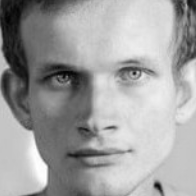

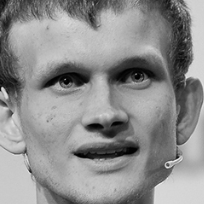

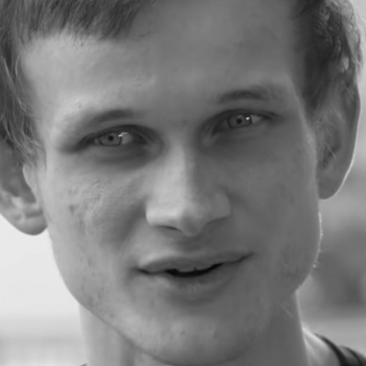

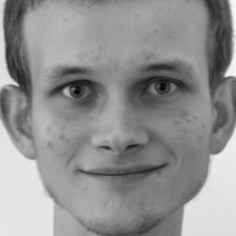

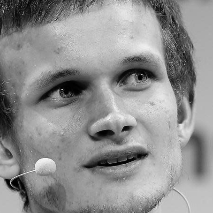

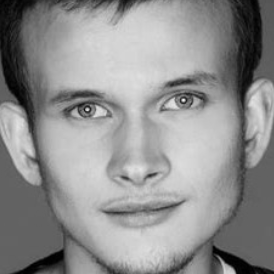

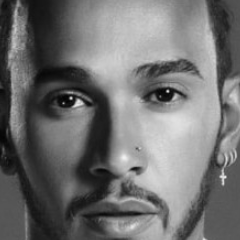

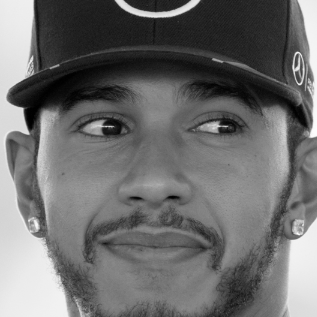

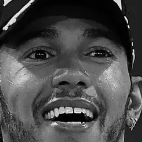

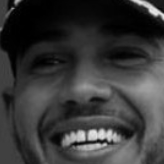

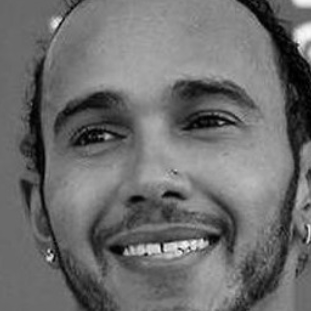

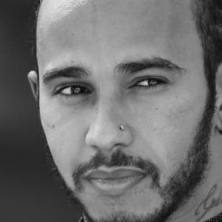

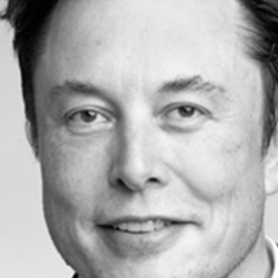

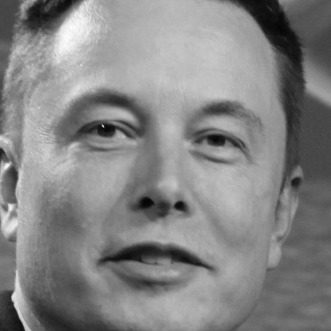

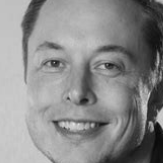

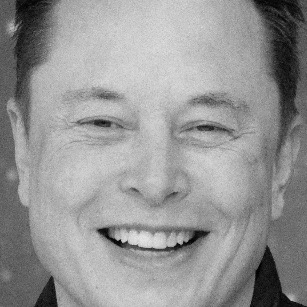

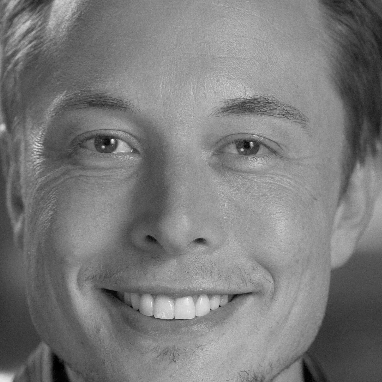

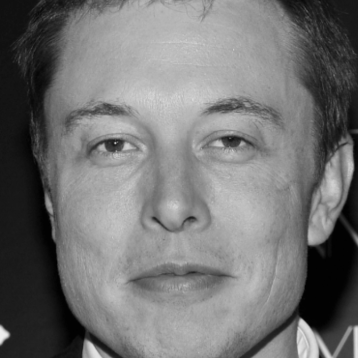

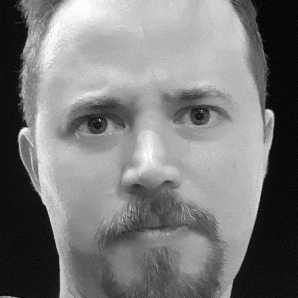

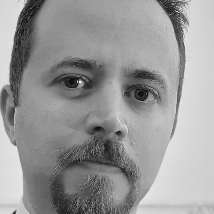

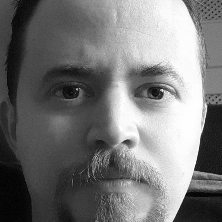

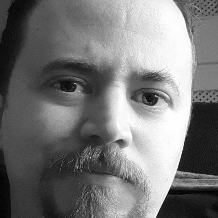

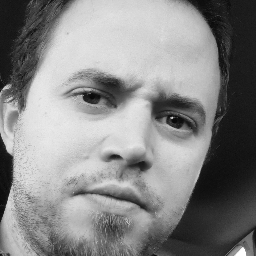

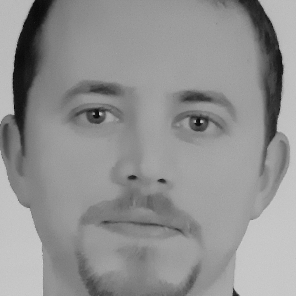

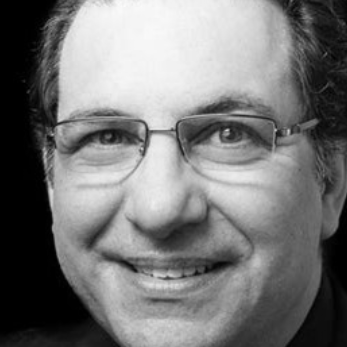

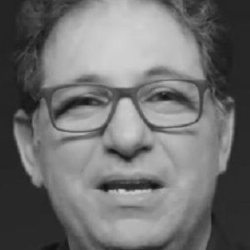

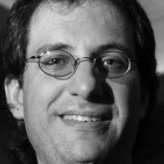

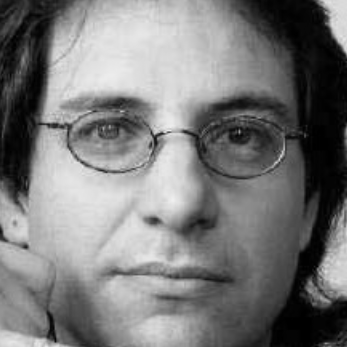

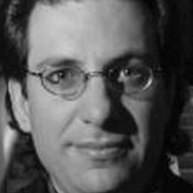

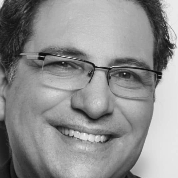

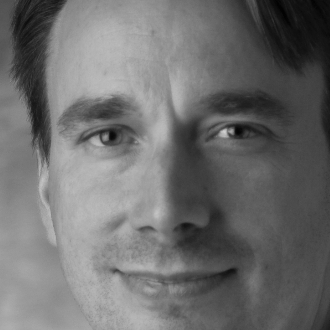

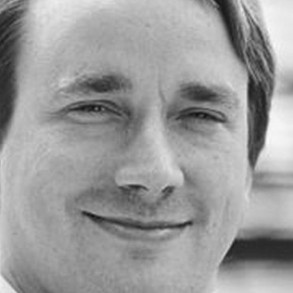

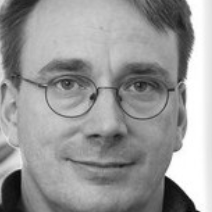

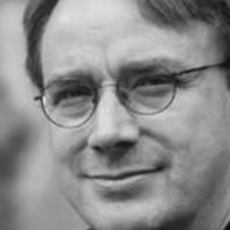

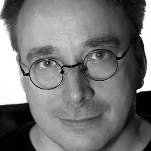

X:  [array([[ 83,  51,  37, ...,  46,  51,  44],
       [ 75,  45,  35, ...,  44,  52,  53],
       [ 71,  41,  32, ...,  43,  50,  57],
       ...,
       [197, 197, 197, ..., 194, 194, 193],
       [196, 197, 196, ..., 194, 194, 193],
       [196, 196, 195, ..., 193, 192, 192]], dtype=uint8), array([[ 29,  22,  26, ..., 208, 208, 209],
       [ 23,  19,  21, ..., 209, 208, 208],
       [ 23,  25,  10, ..., 207, 207, 207],
       ...,
       [201, 201, 201, ..., 210, 212, 210],
       [202, 202, 201, ..., 212, 212, 211],
       [202, 201, 202, ..., 211, 211, 212]], dtype=uint8), array([[ 90,  99,  99, ..., 195, 195, 195],
       [ 92,  99,  93, ..., 195, 195, 195],
       [ 96,  96,  90, ..., 195, 195, 195],
       ...,
       [197, 197, 199, ...,  50,  52,  54],
       [199, 200, 200, ...,  44,  49,  51],
       [202, 203, 203, ...,  44,  52,  54]], dtype=uint8), array([[215, 215, 216, ..., 244, 245, 245],
       [216, 216, 216, ..., 244, 246, 246],
       [218, 219, 212, ..., 244, 2

In [ ]:
X, Y, labels_ids = extractFacesAndLabelsFromDataset(dataset_imgs_folder_path, imgs_formats, img_size, classifier_path, scaleFactor, minNeighbors)
print("X: ", X)
print("Y: ", Y)
print("labels_ids: ", labels_ids)

Enregister les labels (noms des personnes) des visages détectés sur les photos du dataset et leurs identifiants (entiers), dans un fichier "pickle":

In [ ]:
def saveDataInPickleFile(dictio, pickle_file_path):
    import pickle

    with open(pickle_file_path, "wb") as file:
        pickle.dump(dictio, file)
        print("pickle file successfully saved in: {}".format(pickle_file_path))

In [ ]:
pickle_file_path = createFileOrFolderPath(base_path, "labels.pickle")
saveDataInPickleFile(labels_ids, pickle_file_path)

pickle file successfully saved in: /content/drive/MyDrive/photo-face-recognition-app/labels.pickle


# Apprentissage du Modèle:

Nous allons utiliser un classifieur "Haar cascade" pour détecter les visages sur les photos du dataset et les enregistrer sous le dossier "detected_faces" afin de les utiliser plus tard lors de l'étape de Prédiction.

In [ ]:
def instanciateFaceRecognizer():
    import cv2

    recognizer = cv2.face.LBPHFaceRecognizer_create()
    return recognizer

In [ ]:
def trainFaceRecognizer(X, Y, trained_recognizer_file_path):
    import numpy as np

    recognizer = instanciateFaceRecognizer()
    Y = np.array(Y) #convert a list to a numpy array
    recognizer.train(X, Y)
    print("recognizer successfully trained.")
    recognizer.save(trained_recognizer_file_path)  #save the trained data in a YML file
    print("recognizer successfully saved in: {}".format(trained_recognizer_file_path))


Apprentissage avec le classifieur "Haar cascade":

In [ ]:
trained_recognizer_path = createFileOrFolderPath(base_path, "trained_recognizer.yml")
trainFaceRecognizer(X, Y, trained_recognizer_path)

recognizer successfully trained.
recognizer successfully saved in: /content/drive/MyDrive/photo-face-recognition-app/trained_recognizer.yml


le fichier d'output "trained_recognizer.yml" est un classifieur entrainé qui nous permettra par la suite de faire les prédictions.

# Prédiction

Chemin des photos entrées par l'utilisateur:

In [ ]:
input_imgs_folder_path = createFileOrFolderPath(base_path, "input_images")
input_imgs_folder_path

'/content/drive/MyDrive/photo-face-recognition-app/input_images'

In [ ]:
input_imgs = getFolderContent(input_imgs_folder_path)
input_imgs

['20221114_120120.jpg',
 '20220116_155520.jpg',
 '20221119_091607.jpg',
 '20220630_221856.jpg',
 '20221122_215918.jpg']

Chemin des photos des visages détectés, à partir des photos entrées par l'utilisateur:



In [ ]:
detected_faces_folder_path = createFileOrFolderPath(base_path, "detected_faces")

In [ ]:
getFolderContent(detected_faces_folder_path)

['detected_face_1.png',
 'detected_face_2.png',
 'detected_face_3.png',
 'detected_face_4.png',
 'detected_face_5.png']

Saisie des params "scaleFactor" et "minNeighbors" pour la détection des visages sur les photos entrées par l'utilisateur:

In [ ]:
scaleFactor, minNeighbors = setScaleFactorAndMinNeighbors()

entrez les parametres "scaleFactor" et "minNeighbors" de la fct "detectMultiScale()":
scaleFactor (type "float") (ex: 1.3): 1.3
minNeighbors (type "int") (ex: 3): 3


Avant de lancer la prédiction sur les photos entrées par l'utilisateur, il faut au préalable définir les fcts qui permettent de préparer ces photos.

la fct "extractFaceFromImage" permet de lire et de traiter une photo entrées par l'utilisateur puis d'extraires le visage détecté sur cette photo et de l'enregister sous le dossier "detected_faces". elle retourne les coordonnées du visage détecté:

In [ ]:
def extractFaceFromImage(img_path, imgs_formats, img_size, classifier_path, scaleFactor, minNeighbors, detected_face_file_path):
    import cv2

    classifier = cv2.CascadeClassifier(classifier_path)

    if verifyImageFormat(img_path, imgs_formats):

        img_original = readImage(img_path)
        img_resized = resizeImage(img_original, img_size)
        img_grayscale = convertImageToGrayscale(img_resized)

        # displayImageInWindow(str(img_path), img_final)

        # Extraire le visage de la personne sur la photo ainsi que ses coordonnées, en utilisant la fct "detectMultiscale()" du classifieur "Haar cascade"
        detected_faces = classifier.detectMultiScale(img_grayscale, scaleFactor, minNeighbors)

        if len(detected_faces) == 0:  # If we detect no face in the training image
            print("Il n'y a aucun visage sur la photo {}".format(img_path))
        elif len(detected_faces) > 1:  # If we detect more than one face in the training image
            print("Il y a plus qu'un visage sur la photo {}".format(img_path))
        else:  # If we detect one face in the training image (len(detected_faces) == 1)
            for (x, y, width, height) in detected_faces:
                # print(x, y, width, height)
                detected_face_coordinates = (x, y, width, height)
                detected_face = img_grayscale[y: y + height, x: x + width]
                # print(detected_face)
                detected_face_with_colors = img_resized[y: y + height, x: x + width]
                # displayImageInWindow(img_path, detected_face_with_colors)

                # Save the detected face in a file
                writeImage(detected_face_file_path, detected_face)

                return detected_face_coordinates
    else:
        print("le format de l'image {} est incompatible!".format(img_path))


In [ ]:
def readFaceRecognizerTrainedData(trained_recognizer_file_path):
    recognizer = instanciateFaceRecognizer()
    recognizer.read(trained_recognizer_file_path)
    return recognizer

In [ ]:
def readDataFromPickleFile(pickle_file_path):
    import pickle

    with open(pickle_file_path, "rb") as file:
        dictio = pickle.load(file)
        print("pickle file successfully loaded from: {}".format(pickle_file_path))
    return dictio

In [ ]:
def runPredictionOnImage(trained_recognizer_file_path, img_path):
    # lire les données du fichier "trained_recognizer.yml"
    recognizer = readFaceRecognizerTrainedData(trained_recognizer_file_path)
    # lire une image
    img = readImage(img_path)
    # effectuer la prédiction
    id, uncertitude = recognizer.predict(img)   # id: label's id
    print("prediction on image {} done.".format(img_path))
    # print("image label_id: ", id)
    # print("uncertitude : ", uncertitude)
    return id, uncertitude

In [ ]:
# reverse the key/value pair in a dictionnary:
# ex: from {"person_name": id} to {id: "person_name"}
def reverseKeyValuePairInDictio(dictio):
    reversed_dictio = {v: k for k, v in dictio.items()}
    return reversed_dictio

In [ ]:
def getLabelFromId(key, dictio):
    if key in dictio:
        return dictio[key]
    else:
        print("la clé '{}' n'existe pas dans le dictionnaire!".format(key))

In [ ]:
def extractFaceCoordinates(detected_face_coordinates):
    (x, y, width, height) = detected_face_coordinates
    return x, y, width, height

In [ ]:
def drawFrameOnFace(img, face_coordinates):
    import cv2

    (x, y, width, height) = extractFaceCoordinates(face_coordinates)
    frame_color = (0, 255, 0)
    frame_stroke = 2

    cv2.rectangle(img, (x, y), (x + width, y + height), frame_color, frame_stroke)

In [ ]:
def writeTextOnImage(img, face_coordinates, label, uncertitude):
    import cv2

    (x, y, width, height) = extractFaceCoordinates(face_coordinates)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_color_1 = (0, 255, 0)
    font_color_2 = (0, 0, 255)
    font_stroke = 2
    person_name = label.replace("-" or "_", " ")
    uncertitude_value = str("uncertitude = {:.3f}".format(uncertitude))

    cv2.putText(img, person_name, (x, y-20), font, 1, font_color_1, font_stroke, cv2.LINE_AA)
    cv2.putText(img, uncertitude_value, (70, 620), font, 1, font_color_2, font_stroke, cv2.LINE_AA)

In [ ]:
def writeDataOnImage(img_path, img_size, face_coordinates, label, uncertitude):

    img_original = readImage(img_path)
    img_resized = resizeImage(img_original, img_size)

    drawFrameOnFace(img_resized, face_coordinates)
    writeTextOnImage(img_resized, face_coordinates, label, uncertitude)

    displayImageInWindow(img_resized)

Parcours et traitement sur chaque photo entrée par l'utilisateur:

image successfully written in: /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_1.png
prediction on image /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_1.png done.
pickle file successfully loaded from: /content/drive/MyDrive/photo-face-recognition-app/labels.pickle


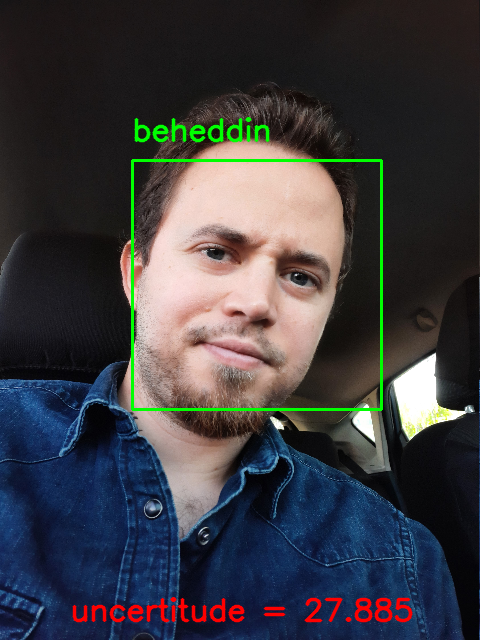

image successfully written in: /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_2.png
prediction on image /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_2.png done.
pickle file successfully loaded from: /content/drive/MyDrive/photo-face-recognition-app/labels.pickle


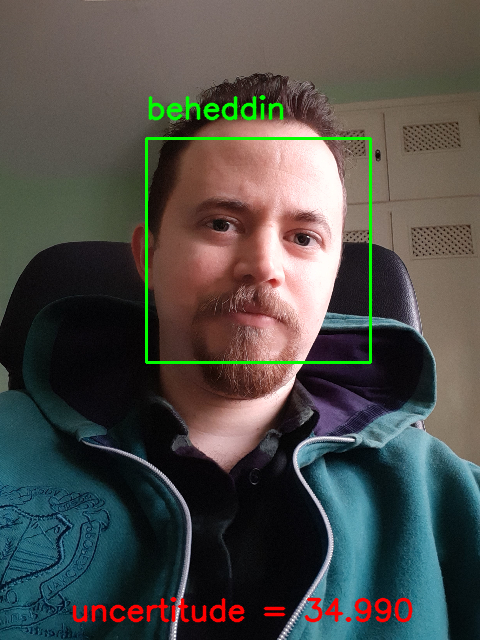

image successfully written in: /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_3.png
prediction on image /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_3.png done.
pickle file successfully loaded from: /content/drive/MyDrive/photo-face-recognition-app/labels.pickle


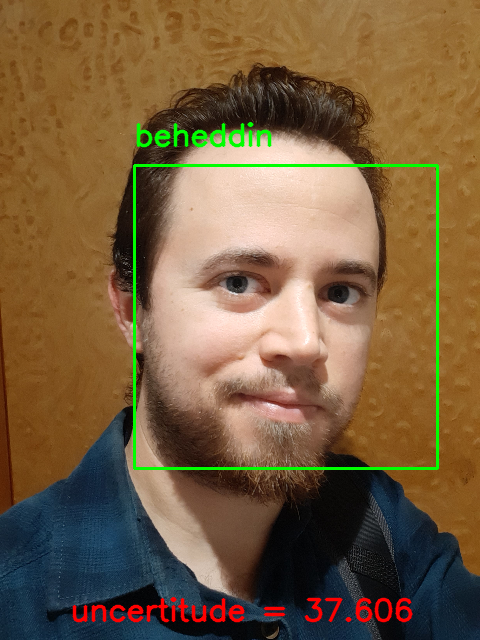

image successfully written in: /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_4.png
prediction on image /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_4.png done.
pickle file successfully loaded from: /content/drive/MyDrive/photo-face-recognition-app/labels.pickle


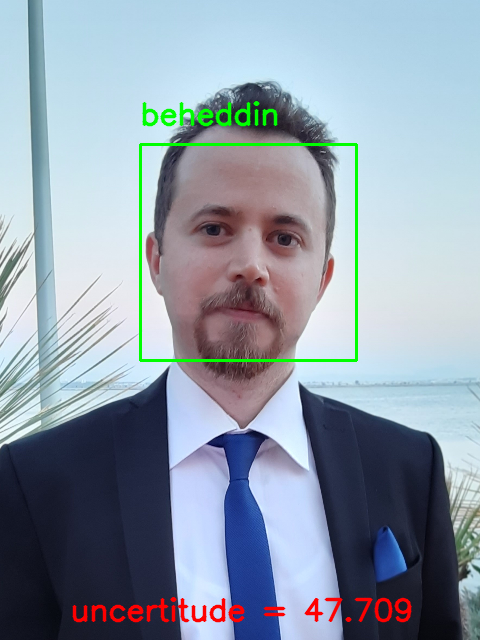

image successfully written in: /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_5.png
prediction on image /content/drive/MyDrive/photo-face-recognition-app/detected_faces/detected_face_5.png done.
pickle file successfully loaded from: /content/drive/MyDrive/photo-face-recognition-app/labels.pickle


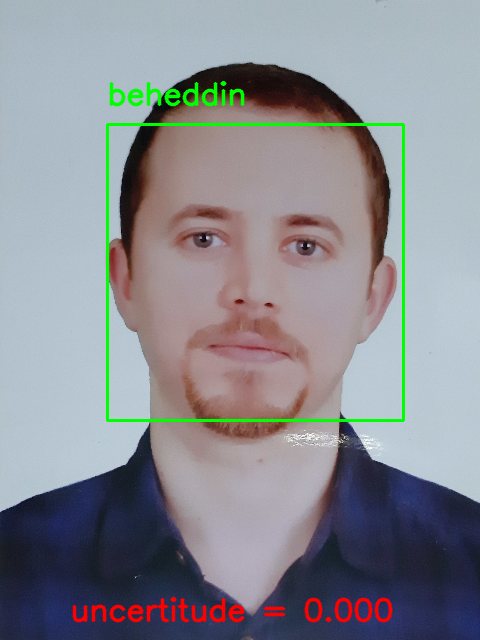

In [ ]:
i = 1
for img in input_imgs:
    img_path = createFileOrFolderPath(input_imgs_folder_path, img)
    # print(img_path)

    detected_face_file_name = "detected_face_" + str(i) + ".png"
    i += 1

    detected_face_file_path = createFileOrFolderPath(detected_faces_folder_path, detected_face_file_name)

    detected_face_coordinates = extractFaceFromImage(img_path, imgs_formats, img_size, classifier_path, scaleFactor, minNeighbors, detected_face_file_path)

    # Prédire l'identité de la personne sur la photo, en se basant sur le classifieur entrainé (trained_recognizer.yml)
    id, uncertitude = runPredictionOnImage(trained_recognizer_path, detected_face_file_path)

    # Charger le fichier "pickle"
    labels_ids_dictio = readDataFromPickleFile(pickle_file_path)

    # Inverser la clé et la valeur dans le dictionnaire contenant les labels (noms des personnes) et leurs identifiants
    ids_labels_dictio = reverseKeyValuePairInDictio(labels_ids_dictio)
    # print("ids_labels_dictio: ", ids_labels_dictio)

    # Extraire les labels (noms des personnes) à partir de leurs identifiants (entier)
    label = getLabelFromId(id, ids_labels_dictio)
    # print(label)

    # Afficher la photo entrée par le user dans une fenetre et écrire les données de prédiction sur cette dernière
    writeDataOnImage(img_path, img_size, detected_face_coordinates, label, uncertitude)